In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from google.colab import drive
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import glob
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Informações sobre o algoritmo.
- No servidor do Neutrinos Angra não tem algumas bibliotecas necessárias para construir o algoritmo da rede neural com kernel RBF. Por este motivo vou rodar este algoritmo no google colab. 


# Importando os arquvos

In [ ]:
# Carrega todos arquivos scv que estão dentro de uma pasta e os armazena em uma lista 
def rot_aux(aux,aux1,ind,ind1):
    df_a   = pd.read_csv(aux1[ind1], skiprows=[0,1,2,3]) # carregar o dataframe que está dentro da pasta 
    rotulo = np.array(aux)[ind][29:len(aux[ind])] # rótulo do banco de dados carregado
    rot    = [] 
    for i in range(len(df_a)):
        rot.append(rotulo)
    df_a['Classes'] = rot # adcionar o rótulo na figura
    return df_a

In [ ]:
# Concatena os arquivos que estão na lista que é obtida pela função rot_aux
def rotular_df(aux,ind): 
    a    = aux[ind] +'/*'
    aux1 = glob.glob(a) #listar as pastas que contém todos os dados de cada exercício
    df = pd.concat([rot_aux(aux,aux1,ind,ind1 = i) for i in range(len(aux1))],ignore_index=True)
    return df

In [ ]:
aux  = glob.glob('/home/antoniojr/notebooks/AReM/*') #listar as pastas que contém todos os dados de cada exercício
df = pd.concat([rotular_df(aux,ind =i) for i in range(len(aux))],ignore_index=True) # dataframe que contém todos os parâmetros 

In [ ]:
df=df.drop('# Columns: time', axis=1) # excluindo a coluna que não tenho interesse ((foi visto que os valores se repetem para cada classe) 

In [ ]:
df.head() # olhando o banco de dados 

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Classes
0,46.25,0.43,18.25,0.43,14.75,0.43,standing
1,46.00,0.71,18.50,0.87,14.25,0.83,standing
2,46.25,0.83,18.50,0.87,13.75,0.83,standing
3,46.25,0.83,18.67,0.47,14.00,0.82,standing
4,46.00,1.00,18.50,0.50,13.25,0.83,standing


# Mudando as label dos dados de target


## Criando as label

In [ ]:
df['Classes'] = df['Classes'].map({'bending1':0, 'bending2':1, 'cycling':2, 'lying':3, 'sitting':4, 'standing':5,
       'walking':6})

In [ ]:
df.Classes.unique()

array([5, 4, 2, 6, 1, 0, 3])

# Modelagem dos modelos

### Separando os dados de treinamento, teste.

In [ ]:
from sklearn.model_selection import train_test_split 

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df[df.columns[0:-1]], np.ravel(df['Classes']), test_size=0.40, random_state=101)

Foi separado 70 % dos dados para treinamento, 30 % para teste.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5) # selecionado 5 folds para realizar a validação cruzada

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix # importar matriz de confusão

# rede RBF

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.preprocessing import OneHotEncoder


#Determinação da rede:
def RBFN(xTrain, yTrain, neurons):
    #Determinar centróide dos clusters: (centro das gaussianas de cada neurônio)
    K_cent = neurons
    km     = KMeans(n_clusters= K_cent, max_iter= 200)
    km.fit(xTrain)
    cent   = km.cluster_centers_
    #Cálculo do sigma:
    dist_vector = distance.pdist(cent,'euclidean')
    dist_matrix = distance.squareform(dist_vector)
    sigma       = dist_matrix.max()/(np.sqrt(2*neurons))
    #Codificando a matriz de labels:
    encoder  = OneHotEncoder()
    yTrain   = encoder.fit_transform(yTrain.reshape(-1,1)).toarray()
    #Cálculo da gaussiana em cada dado de treinamento:
    shape  = xTrain.shape
    row    = shape[0]
    column = neurons
    phi    = np.zeros((row,column), dtype= float)
    for i in range(row):
        for j in range(column):
            dist     = np.linalg.norm(xTrain[i]-cent[j])
            phi[i,j] = np.exp(-(dist**2)/(2*(sigma**2)))
    #Cálculo da pseudo-inversa:
    w = np.linalg.inv(phi.T @ phi) @ (phi.T @ yTrain)
    return w, cent, sigma



In [ ]:
#Eficiência da rede utilizando os valores de w:

def RBFN_score(xTest, yTest, w, cent, sigma):
    row      = xTest.shape[0]
    column   = len(w)
    phiTest  = np.zeros((row,column), dtype= float)
    for i in range(row):
        for j in range(column):
            distTest      = np.linalg.norm(xTest[i]-cent[j])
            phiTest[i,j]  = np.exp(-(distTest**2)/(2*(sigma**2)))
    predTest   = phiTest @ w
    prediction = np.zeros([predTest.shape[0],predTest.shape[1]])
    for i in range(len(predTest)):
        ind = np.where(predTest[i] == max(predTest[i]))
        prediction[i,ind] = 1
    encoder    = OneHotEncoder()
    yTest   = encoder.fit_transform(yTest.reshape(-1,1)).toarray()
    prediction = encoder.inverse_transform(prediction)
    
    return prediction

In [ ]:
er_trein_rbf = []
er_val_rbf = []


neurons      = range(2,160,5)
rbf_v        = np.zeros((5,len(neurons)))
scaler       = StandardScaler() 
j = 0
for linhas_treino, linhas_valid in kf.split(X_train1):
    
    X_t, X_v = X_train1.iloc[linhas_treino], X_train1.iloc[linhas_valid]
    y_t, y_v = y_train1[linhas_treino], y_train1[linhas_valid]
     # como todos os classificadores são baseados em distância, vou normalizar os dados 
    X_t     = scaler.fit_transform(X_t) # dados de treinamento normalizado
    X_v     = scaler.fit_transform(X_v) # dados de validação normalizado
    #y_t = y_t
    #y_v = y_v

    for i  in range(len(neurons)):
        w,cent,sigma = RBFN(X_t, y_t, neurons =neurons[i])
        saida       = RBFN_score(X_v, y_v, w, cent, sigma)
        rbf         = np.sum(saida.reshape(1,len(saida)) == y_v)/len(saida)
        rbf_v[j][i] = rbf
    j = j +1
 

In [ ]:
#np.save('/content/drive/My Drive/rbf_v', rbf_v)


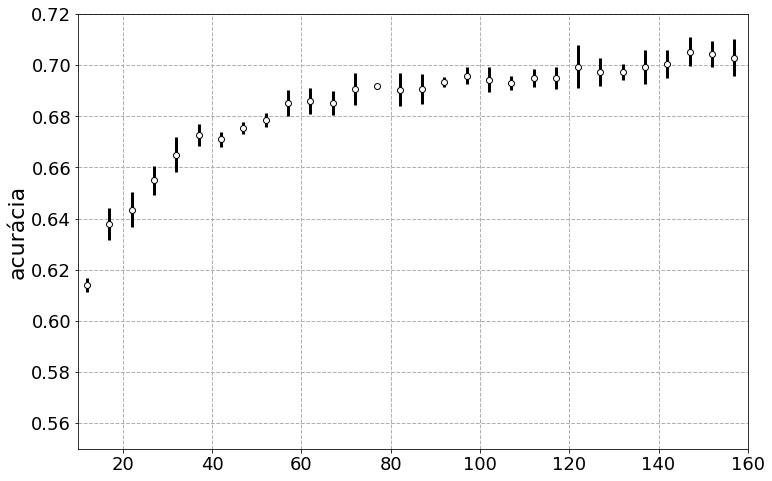

In [ ]:
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.figure(figsize=(12,8))
plt.errorbar(neurons,np.mean(rbf_v,axis= 0),np.std(rbf_v,axis= 0),fmt ='o',color='black',ecolor='black', elinewidth=3,ls="none",mfc="w",label = 'C =1')

#plt.legend()
plt.grid(linestyle='--', linewidth=1)
plt.ylabel('acurácia', size=22)
#plt.xlabel('Valores de gamma', size=22)
plt.ylim(0.55,0.72)
plt.xlim(10,160)
plt.show()

In [ ]:
print('Acurácia = ',np.mean(rbf_v,axis= 0)[np.argmax(np.mean(rbf_v,axis= 0))],'desvio padrão = ',np.std(rbf_v,axis= 0)[np.argmax(np.mean(rbf_v,axis= 0))],'Número de neurônios = ',neurons[np.argmax(np.mean(rbf_v,axis= 0))])

Acuráácia =  0.7052044454250366 desvio padrão =  0.005716392184837926 Número de neurônios =  147


# Verificando a importancia dos parâmetros para o modelo


In [ ]:
rbf_p = np.zeros((5,X_t.shape[1]))
j =0

In [ ]:
for linhas_treino, linhas_valid in kf.split(X_train1):
    
       
    X_t, X_v = X_train1.iloc[linhas_treino], X_train1.iloc[linhas_valid]
    y_t, y_v = y_train1[linhas_treino], y_train1[linhas_valid]
    # como todos os classificadores são baseados em distância, vou normalizar os dados 
    X_t     = scaler.fit_transform(X_t) # dados de treinamento normalizado
    X_v     = scaler.fit_transform(X_v) # dados de validação normalizado

    for i in range(X_t.shape[1]):
        w,cent,sigma = RBFN(X_t, y_t, neurons =neurons[i])
        saida       = RBFN_score(X_v, y_v, w, cent, sigma)
        rbf         = np.sum(saida.reshape(1,len(saida)) == y_v)/len(saida)
        rbf_p[j][i] = rbf
    
    j =  j + 1
    print(j)      

1
2
3
4
5


In [ ]:
acerto_vm = np.mean(rbf_p, axis =0)
acerto_vs = np.std(rbf_p, axis =0)

In [ ]:
acerto_V = np.zeros(X_t.shape[1]+1)
at = np.mean(rbf_v,axis = 0)
acerto_V[0] = at[np.argmax(at)]
acerto_V[1:] = acerto_vm


acerto_S = np.zeros(X_t.shape[1]+1)
at = np.std(rbf_v,axis = 0)
acerto_S[0] = at[np.argmax(at)]
acerto_S[1:] = acerto_vs

In [ ]:
x = ['Todos','avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23',
       'var_rss23', 'Classes']

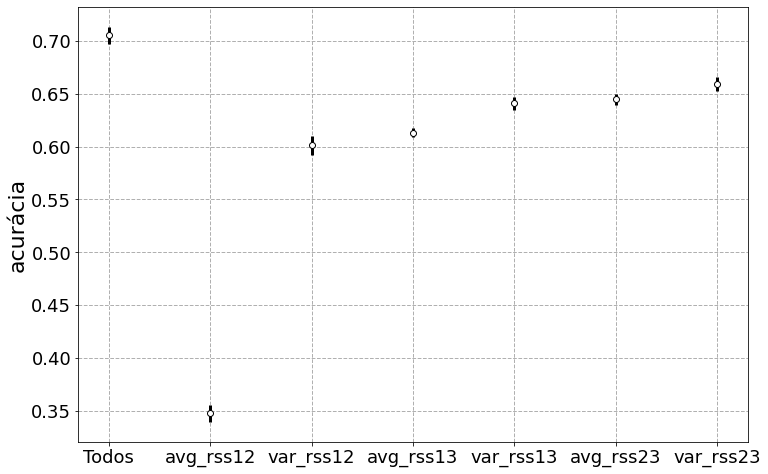

In [ ]:
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.figure(figsize=(12,8))
plt.errorbar(np.arange(X_t.shape[1]+1),acerto_V,acerto_S,fmt ='o',color='black',ecolor='black', elinewidth=3,ls="none",mfc="w",label = 'C =1')
plt.grid(linestyle='--', linewidth=1)
plt.ylabel('acurácia', size=22)
ax = plt.gca()
ax.set_xticks(np.arange(X_t.shape[1]+1))
ax.set_xticklabels(x)
plt.show()

### A última parte que está no notebook Trabalho_parte_3 contém avaliação dos modelos, e mostra qual delas é melhor.